- https://www.rottentomatoes.com/top/bestofrt/?year=2020
- https://www.rottentomatoes.com/top/bestofrt/?year=2010
	- det er top 100 film fra et givent år

- Scrape navn, genre, runtime, tomatometer score og audience score på filmene fra årstallet 2020 og 2000
	- Hvis en film har flere genre så tilhører den alle de forskellige genre grupper

- Vis den gennemsnitlige audience score for hver genre i 2020 og 2000, i den samme barchart

- Find den genre hvor der er størst forskel fra audience score og tomatometer score i 2000
	- har det ændret sig i 2020?
	- hvis ja
		- vis en barchart af de forskellige genre

- Hvad er den gennemsnitlige runtime for genren 'drama' i 2010 og 2020?

In [20]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import requests
import json
import bs4

def download(url):
  r = requests.get(url)
  if(r.status_code != 200):
    raise FileNotFoundError
  return bs4.BeautifulSoup(r.text, 'html.parser')

def get_top100_links(year):
    profile = webdriver.FirefoxProfile()
    profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
    
    # headless is needed here because we do not have a GUI version of firefox
    options = Options()
    options.headless = True
    # driver = webdriver.Firefox(options=options, executable_path=r'/tmp/geckodriver')
    browser = webdriver.Firefox(options=options, executable_path=r'/tmp/geckodriver')
    try:
      browser.get('https://www.rottentomatoes.com/top/bestofrt/?year='+year)
      table = browser.find_element_by_class_name("table")
      rows = table.find_elements_by_tag_name("tr")
      idx = 1
      urls = []
      for row in rows:
          if idx <= 100:
            link = browser.find_element_by_xpath('/html/body/div[5]/div[2]/div[1]/section/div/table/tbody/tr['+str(idx)+']/td[3]/a')
            urls.append(link.get_attribute("href"))
            idx+=1
            
      return urls
    except:
      print('Failed to fetch all links')  

def threaded_download(url_list):
  with ThreadPoolExecutor(5) as ex:
    return list(ex.map(download, url_list))

def get_movies_by_url(urls):
    
    movies = threaded_download(urls)
    movie_data =[]

    for movie in movies:
        #Henter data fra script tag på RT
        script_tag = movie.select_one('#score-details-json').text
        data = json.loads(script_tag)
        title = data['scoreboard']['title']
        audience_score = data['scoreboard']['audienceScore']
        tomatometer_score = data['scoreboard']['tomatometerScore']
        runtime = data['scoreboard']['info'].split(',')[-1].strip()
    
        genres = movie.find('div', 'meta-value genre')
        if(genres != None):
            genres_split = genres.text.strip().split(',')
            for genre in genres_split:
                info = [title,runtime,genre.strip(),tomatometer_score,audience_score]
                movie_data.append(info)
        else:
            info = [title,runtime,'No Genre',tomatometer_score,audience_score]
            movie_data.append(info)
    return movie_data

movies_from_2020 = get_movies_by_url(get_top100_links('2020'))
movies_from_2000 = get_movies_by_url(get_top100_links('2000'))


df_movies_2020 = pd.DataFrame(movies_from_2020, columns=['Title','Runtime','Genre','Tomatometer Score','Audience Score'])
df_movies_2000 = pd.DataFrame(movies_from_2000, columns=['Title','Runtime','Genre','Tomatometer Score','Audience Score'])
df_movies_2000['Year']='2000'
df_movies_2020['Year']='2020'

   

Genre
War                   19.000000
Horror                17.000000
Biography             17.000000
Western               15.000000
Lgbtq+                13.750000
Animation             12.200000
Kids & family         11.714286
Adventure             11.700000
Sci-fi                 9.500000
Comedy                 8.172414
Documentary            7.142857
Fantasy                6.000000
Action                 6.000000
Musical                6.000000
Romance                5.818182
Mystery & thriller     5.555556
Crime                  2.750000
Music                  1.000000
Drama                  0.905660
History                0.857143
No Genre               0.000000
dtype: float64

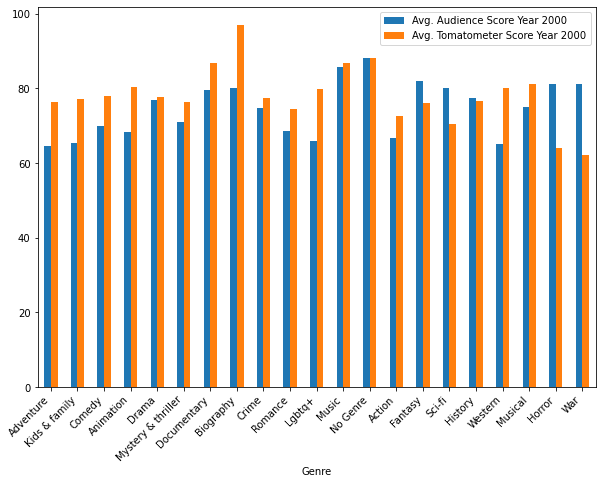

In [60]:
#Ratings from 2000
avg_audienceScore_2000 = df_movies_2000['Audience Score'].sum()/len(df_movies_2000['Audience Score'])


#find de unikke genrer
genres_2000 = pd.unique(df_movies_2000['Genre'])

avg_audienceScore_2000 = []
for genre in genres_2000:
   avg_audienceScore_2000.append([genre,df_movies_2000[df_movies_2000['Genre'] == genre]['Audience Score'].sum()/len(df_movies_2000[df_movies_2000['Genre'] == genre]),df_movies_2000[df_movies_2000['Genre'] == genre]['Tomatometer Score'].sum()/len(df_movies_2000[df_movies_2000['Genre'] == genre])])

avg_audiencescore_pr_genre_2000 = pd.DataFrame(avg_audienceScore_2000, columns=['Genre','Avg. Audience Score Year 2000', 'Avg. Tomatometer Score Year 2000'])

#avg_audiencescore_pr_genre_2000
avg_audiencescore_pr_genre_2000 = avg_audiencescore_pr_genre_2000.set_index('Genre')
avg_audiencescore_pr_genre_2000.plot.bar()
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light')

#Calculate Difference between audience and Tomato score per Genre
abs(avg_audiencescore_pr_genre_2000['Avg. Audience Score Year 2000']-avg_audiencescore_pr_genre_2000['Avg. Tomatometer Score Year 2000']).sort_values(ascending=False)

Genre
Horror                30.727273
Mystery & thriller    28.727273
Crime                 28.000000
Drama                 27.690476
Sci-fi                25.500000
Comedy                22.826087
Documentary           20.696970
War                   19.500000
Western               15.500000
Music                 15.400000
Romance               15.000000
Biography             14.000000
No Genre              13.000000
Lgbtq+                12.400000
Action                11.000000
Musical               10.500000
Fantasy                9.333333
History                7.500000
Adventure              6.000000
Kids & family          5.333333
Animation              4.250000
dtype: float64

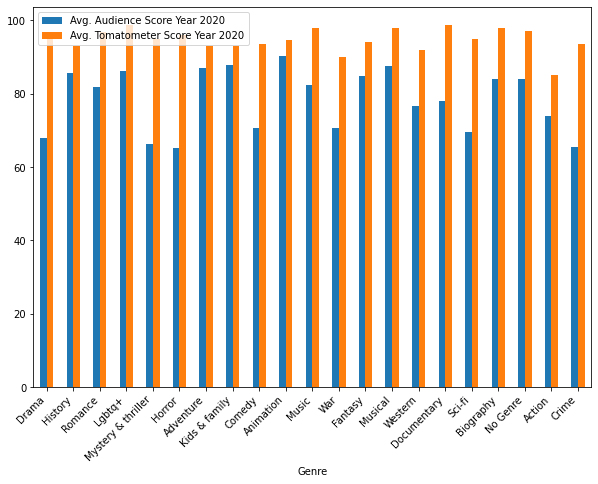

In [58]:
#Ratings from 2020
avg_audienceScore_2020 = df_movies_2020['Audience Score'].sum()/len(df_movies_2020['Audience Score'])

#find de unikke genrer
genres_2020 = pd.unique(df_movies_2020['Genre'])

avg_audienceScore_2020 = []
for genre in genres_2020:
   avg_audienceScore_2020.append([genre,df_movies_2020[df_movies_2020['Genre'] == genre]['Audience Score'].sum()/len(df_movies_2020[df_movies_2020['Genre'] == genre]),df_movies_2020[df_movies_2020['Genre'] == genre]['Tomatometer Score'].sum()/len(df_movies_2020[df_movies_2020['Genre'] == genre])])

avg_audiencescore_pr_genre_2020 = pd.DataFrame(avg_audienceScore_2020, columns=['Genre','Avg. Audience Score Year 2020', 'Avg. Tomatometer Score Year 2020'])

#avg_audiencescore_pr_genre_2020

avg_audiencescore_pr_genre_2020 = avg_audiencescore_pr_genre_2020.set_index('Genre')
avg_audiencescore_pr_genre_2020.plot.bar()
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light')

#Calculate Difference between audience and Tomato score per Genre
abs(avg_audiencescore_pr_genre_2020['Avg. Audience Score Year 2020']-avg_audiencescore_pr_genre_2020['Avg. Tomatometer Score Year 2020']).sort_values(ascending=False)



AttributeError: 'DataFrame' object has no attribute 'get_figure'